In [1]:
from datasetsforecast.long_horizon2 import LongHorizon2
import pandas as pd
import logging

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoInformer
from neuralforecast.losses.pytorch import MSE
import torch
from optuna import Trial
import matplotlib.pyplot as plt
from neuralforecast.losses.numpy import mse


torch.set_float32_matmul_precision("high")

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

/root/NAS-LLM-Agent/.venv/lib/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [2]:
def train_optuna(dataset_group: str = "ETTh1", num_samples=25, horizon = 168):
    Y_df = LongHorizon2.load(directory="data", group=dataset_group)
    Y_df["ds"] = pd.to_datetime(Y_df["ds"])

    n_time = len(Y_df.ds.unique())
    val_size = int(0.2 * n_time)
    test_size = int(0.2 * n_time)

    horizon = horizon

    def get_config(trial: Trial):
        config = {
            "input_size": trial.suggest_categorical("input_size", [horizon]),
            "hidden_size": trial.suggest_categorical(
                "hidden_size", [32, 64, 128, 256]
            ),
            "n_head": trial.suggest_categorical("n_head", [2, 4, 8, 16]),
            "dropout": trial.suggest_categorical("dropout", [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]),
            "conv_hidden_size": trial.suggest_categorical(
                "conv_hidden_size", [8, 16, 32, 64]
            ),
            "distil": trial.suggest_categorical("distil", [True, False]),
            "activation": trial.suggest_categorical("activation", ["relu", "gelu"]),
            "encoder_layers": trial.suggest_categorical("encoder_layers", [1, 2, 3, 4, 6]),
            "decoder_layers": trial.suggest_categorical("decoder_layers", [1, 2]),
            "learning_rate": trial.suggest_categorical("learning_rate", [1e-4]),
            "scaler_type": trial.suggest_categorical("scaler_type", ["robust"]),
            "max_steps": trial.suggest_categorical("max_steps", [8]),
            "val_check_steps": trial.suggest_categorical("val_check_steps", [8]),
            "batch_size": trial.suggest_categorical("batch_size", [32]),
            "windows_batch_size": trial.suggest_categorical(
                "windows_batch_size", [1024]
            ),
            "random_seed": trial.suggest_categorical("random_seed", [1]),
        }
        return config

    models = [
        AutoInformer(
            h=horizon, loss=MSE(), num_samples=num_samples, config=get_config, backend="optuna"
        ),
    ]
    nf = NeuralForecast(models=models, freq="h")
    Y_hat_df = nf.cross_validation(
        df=Y_df, val_size=val_size, test_size=test_size, n_windows=None
    )

    best_params = nf.models[0].results.best_params
    print(best_params)

    Y_plot = Y_hat_df[Y_hat_df["unique_id"] == "OT"]  # OT dataset
    cutoffs = Y_hat_df["cutoff"].unique()[::horizon]
    Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]

    plt.figure(figsize=(20, 5))
    plt.plot(Y_plot["ds"], Y_plot["y"], label="True")
    plt.plot(Y_plot["ds"], Y_plot["AutoInformer"], label="AutoInformer")
    plt.xlabel("Datestamp")
    plt.ylabel("OT")
    plt.grid()
    plt.legend()

    mse_informer = mse(Y_hat_df["y"], Y_hat_df["AutoInformer"])
    print(f"Informer: {mse_informer:.3f}")

    return nf, Y_hat_df

[I 2025-11-21 15:54:59,733] A new study created in memory with name: no-name-64432901-76ee-4040-bab8-3e87a892cf44
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:07,242] Trial 0 finished with value: 1.224674940109253 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 8, 'distil': False, 'activation': 'gelu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:12,692] Trial 1 finished with value: 1.3025317192077637 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 8, 'dropout': 0.3, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:17,969] Trial 2 finished with value: 1.4711335897445679 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 16, 'dropout': 0.3, 'conv_hidden_size': 16, 'distil': False, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:21,680] Trial 3 finished with value: 1.2392276525497437 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 4, 'dropout': 0, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:37,020] Trial 4 finished with value: 1.2512149810791016 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 4, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': False, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:41,759] Trial 5 finished with value: 1.2849072217941284 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 8, 'dropout': 0, 'conv_hidden_size': 32, 'distil': True, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:55:57,915] Trial 6 finished with value: 1.24253249168396 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 16, 'dropout': 0.05, 'conv_hidden_size': 64, 'distil': False, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:03,585] Trial 7 finished with value: 1.2353438138961792 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 2, 'dropout': 0.05, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:11,477] Trial 8 finished with value: 1.2829856872558594 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 2, 'dropout': 0.5, 'conv_hidden_size': 16, 'distil': False, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:15,531] Trial 9 finished with value: 1.3520853519439697 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 16, 'dropout': 0.05, 'conv_hidden_size': 8, 'distil': True, 'activation': 'gelu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:24,995] Trial 10 finished with value: 1.2453898191452026 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 8, 'distil': False, 'activation': 'relu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:27,720] Trial 11 finished with value: 1.4667820930480957 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 8, 'distil': False, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 1.224674940109253.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:34,297] Trial 12 finished with value: 1.208376169204712 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:40,869] Trial 13 finished with value: 1.2297508716583252 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.4, 'conv_hidden_size': 8, 'distil': False, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:56:54,796] Trial 14 finished with value: 1.2086669206619263 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:08,748] Trial 15 finished with value: 1.2101536989212036 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:22,779] Trial 16 finished with value: 1.2101551294326782 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:32,854] Trial 17 finished with value: 1.2700492143630981 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 4, 'dropout': 0.2, 'conv_hidden_size': 32, 'distil': False, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:36,743] Trial 18 finished with value: 1.3684728145599365 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 8, 'dropout': 0.5, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:40,650] Trial 19 finished with value: 1.309575080871582 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.4, 'conv_hidden_size': 64, 'distil': False, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:57:50,171] Trial 20 finished with value: 1.2280397415161133 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 16, 'distil': False, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:58:04,144] Trial 21 finished with value: 1.2101553678512573 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:58:18,162] Trial 22 finished with value: 1.2101507186889648 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:58:32,287] Trial 23 finished with value: 1.2101538181304932 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 15:58:46,359] Trial 24 finished with value: 1.2101521492004395 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 12 with value: 1.208376169204712.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

{'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
Informer: 0.615


/tmp/ipykernel_8369/3606347828.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


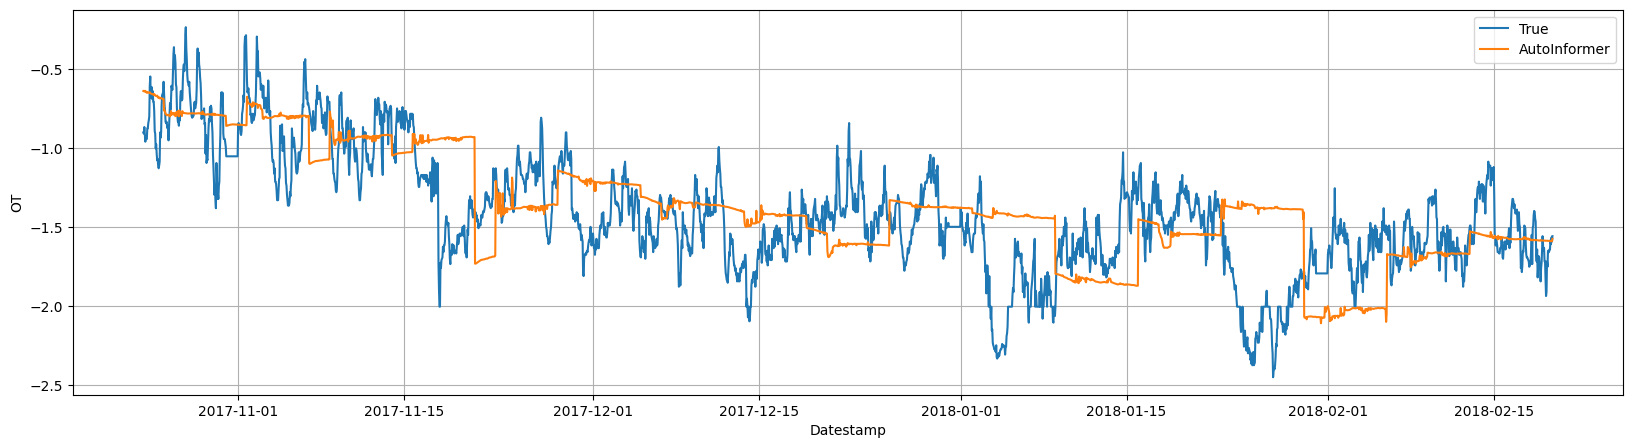

In [3]:
nf, Y_hat_df = train_optuna(dataset_group="ETTh1")

[I 2025-11-21 16:04:21,738] A new study created in memory with name: no-name-2f204bf0-52cc-4b9a-87fa-20fed9277fd3
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:04:28,790] Trial 0 finished with value: 0.33875879645347595 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 8, 'dropout': 0, 'conv_hidden_size': 16, 'distil': True, 'activation': 'relu', 'encoder_layers': 1, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 0 with value: 0.33875879645347595.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:04:34,349] Trial 1 finished with value: 0.3039918541908264 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 4, 'dropout': 0.1, 'conv_hidden_size': 32, 'distil': False, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 1 with value: 0.3039918541908264.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:04:48,671] Trial 2 finished with value: 0.5545421838760376 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 4, 'dropout': 0, 'conv_hidden_size': 16, 'distil': False, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 1 with value: 0.3039918541908264.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:04:50,791] Trial 3 finished with value: 0.27572354674339294 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.4, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:04:58,765] Trial 4 finished with value: 0.30939528346061707 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 4, 'dropout': 0.4, 'conv_hidden_size': 64, 'distil': False, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:01,936] Trial 5 finished with value: 0.29803380370140076 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 8, 'dropout': 0.4, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 4, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:06,369] Trial 6 finished with value: 0.29888156056404114 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 4, 'dropout': 0.05, 'conv_hidden_size': 8, 'distil': True, 'activation': 'gelu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:20,339] Trial 7 finished with value: 0.7328307628631592 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.5, 'conv_hidden_size': 64, 'distil': False, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:23,405] Trial 8 finished with value: 0.29773420095443726 and parameters: {'input_size': 168, 'hidden_size': 64, 'n_head': 8, 'dropout': 0, 'conv_hidden_size': 8, 'distil': True, 'activation': 'gelu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:30,996] Trial 9 finished with value: 0.35339829325675964 and parameters: {'input_size': 168, 'hidden_size': 128, 'n_head': 8, 'dropout': 0.3, 'conv_hidden_size': 32, 'distil': True, 'activation': 'relu', 'encoder_layers': 6, 'decoder_layers': 2, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 3 with value: 0.27572354674339294.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:33,060] Trial 10 finished with value: 0.2756202816963196 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:36,082] Trial 11 finished with value: 0.27562323212623596 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:38,202] Trial 12 finished with value: 0.2756215035915375 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:42,434] Trial 13 finished with value: 0.3344615697860718 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:44,441] Trial 14 finished with value: 0.275623083114624 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:46,455] Trial 15 finished with value: 0.2756226360797882 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:50,584] Trial 16 finished with value: 0.334462434053421 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 16, 'dropout': 0.2, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 2, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:05:52,543] Trial 17 finished with value: 0.31640058755874634 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.05, 'conv_hidden_size': 16, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:01,981] Trial 18 finished with value: 1.07058584690094 and parameters: {'input_size': 168, 'hidden_size': 256, 'n_head': 2, 'dropout': 0.3, 'conv_hidden_size': 8, 'distil': False, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 10 with value: 0.2756202816963196.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:04,025] Trial 19 finished with value: 0.2755219340324402 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:08,126] Trial 20 finished with value: 0.29559847712516785 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 16, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 1, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:10,157] Trial 21 finished with value: 0.2755226790904999 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:12,200] Trial 22 finished with value: 0.27552926540374756 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:14,234] Trial 23 finished with value: 0.2755238115787506 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2025-11-21 16:06:16,357] Trial 24 finished with value: 0.3104730248451233 and parameters: {'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 4, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}. Best is trial 19 with value: 0.2755219340324402.
INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

{'input_size': 168, 'hidden_size': 32, 'n_head': 2, 'dropout': 0.1, 'conv_hidden_size': 64, 'distil': True, 'activation': 'gelu', 'encoder_layers': 3, 'decoder_layers': 1, 'learning_rate': 0.0001, 'scaler_type': 'robust', 'max_steps': 8, 'val_check_steps': 8, 'batch_size': 32, 'windows_batch_size': 1024, 'random_seed': 1}
Informer: 0.389


/tmp/ipykernel_8369/3606347828.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df["cutoff"].isin(cutoffs)]


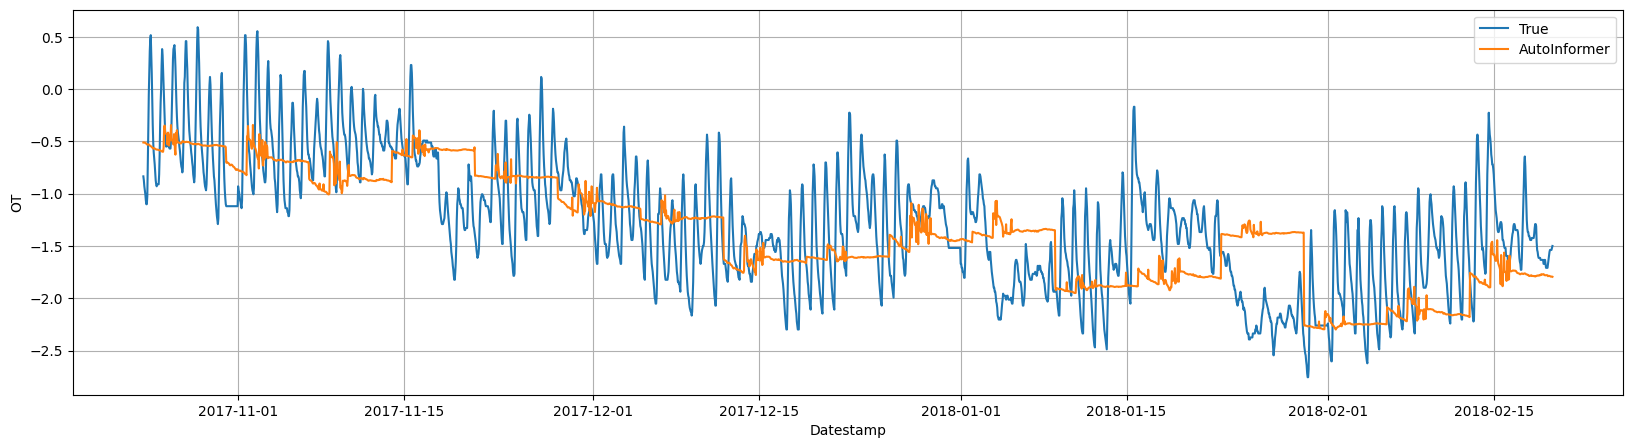

In [6]:
nf2, Y_hat_df2 = train_optuna(dataset_group="ETTh2")